[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/14thApostle/ME6324-Steel-Defect-segmentation/blob/main/unet_train.ipynb)

In [1]:
# Basic libs
import os
from os.path import join
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# Torch stuff
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Augmentations and plotting
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise, RandomBrightnessContrast)
from albumentations.pytorch import ToTensor

## Set random seeds
seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device",device)

Using device cuda:0


In [2]:
data_folder = './severstal-steel-defect-detection'
train_df_path = join(data_folder, 'train.csv')
train_imgs_folder = join(data_folder, 'train_images')

phases = ['train', 'val']
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
batch_size = 16
num_workers = 4
lr = 5e-4
EPOCHS = 20

## Helper functions

For our given dataset, the masks are encoded as the masks are a very sparse representations and they are encoded to save space. Helper functions from https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode are used

In [3]:
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

## Dataloader

In [4]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = join(train_imgs_folder,  image_id)
        
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 4x256x1600
        return img, mask    

def get_transforms(phase, mean, std):
    transforms = []
    if phase == "train":
        transforms.extend(
            [
                HorizontalFlip(p=0.5), 
                RandomBrightnessContrast(p=0.5),
                GaussNoise(),
                ShiftScaleRotate(p=0.4),
            ]
        )
    transforms.extend(
        [
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensor(),
        ]
    )
    transforms = Compose(transforms)
    return transforms


df = pd.read_csv(train_df_path)
df['ClassId'] = df['ClassId'].astype(int)
df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
df['defects'] = df.count(axis=1)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
train_df.to_csv('train_1.csv')
val_df.to_csv('val_1.csv')

dataloaders = {}
for phase in phases:
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
        drop_last = True,        
    )
    dataloaders[phase] = dataloader

print(dataloaders)


{'train': <torch.utils.data.dataloader.DataLoader object at 0x000002E38D8FB1F0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x000002E3F98FD490>}


## Utility functions

Dice and IoU metric implementations, metric logger for training and validation.

In [5]:
def predict(X, threshold):
    X_p = np.copy(X)
    return (X_p > threshold).astype('uint8')

def metric(probability, truth, threshold=0.5, reduction='none'):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        p_sum = p.sum(-1)
        t_sum = t.sum(-1)
        
        pos_index = torch.nonzero(t_sum >= 1)
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos])

        num_pos = len(pos_index)

    return dice, dice_pos, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 
        self.base_dice_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_pos, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) 
    labels = np.array(labels)
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## Model Initialization

In [12]:
from segmentation_models_pytorch import Unet
model = Unet("resnet18", encoder_weights="imagenet", classes=4, activation=None)
model = model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=3, verbose=True)

### Training and Validation

In [13]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model, dataloaders):
        self.num_workers = num_workers
        self.batch_size = {"train": batch_size, "val": batch_size}
        self.accumulation_steps = batch_size // self.batch_size['train']
        self.lr = lr
        self.num_epochs = EPOCHS
        
        self.best_loss = float("inf")
        self.phases = phases
        self.device = device

        if device == "cuda:0":
            torch.set_default_tensor_type("torch.cuda.FloatTensor")
        else:
            torch.set_default_tensor_type("torch.FloatTensor")
        
        self.net = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.dataloaders = dataloaders
        
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        #  Get pred and loss
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")

        if phase == "train":
            self.net.train()
        else:
            self.net.eval()

        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        dataloader1 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        
        for itr, batch in enumerate(dataloader1): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            if phase == "train":
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            dataloader1.set_postfix(loss=(running_loss / ((itr + 1))))
        
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)

        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./best_model.pth")
            print()


In [ ]:
model_trainer = Trainer(model, dataloaders)
model_trainer.start()

  0%|          | 0/334 [00:00<?, ?it/s]

Starting epoch: 0 | phase: train | ⏰: 13:55:20


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.1409 | IoU: 0.2656 | dice: 0.3569 | dice_neg: nan | dice_pos: 0.3569
Starting epoch: 0 | phase: val | ⏰: 14:03:53


100%|██████████| 84/84 [00:59<00:00,  1.41it/s]


Loss: 0.0357 | IoU: 0.3020 | dice: 0.4048 | dice_neg: nan | dice_pos: 0.4048
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 1 | phase: train | ⏰: 14:04:53


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0314 | IoU: 0.3708 | dice: 0.4812 | dice_neg: nan | dice_pos: 0.4812
Starting epoch: 1 | phase: val | ⏰: 14:13:10


100%|██████████| 84/84 [00:56<00:00,  1.48it/s]


Loss: 0.0296 | IoU: 0.2990 | dice: 0.3917 | dice_neg: nan | dice_pos: 0.3917
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 2 | phase: train | ⏰: 14:14:07


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0269 | IoU: 0.3943 | dice: 0.5030 | dice_neg: nan | dice_pos: 0.5030
Starting epoch: 2 | phase: val | ⏰: 14:22:04


100%|██████████| 84/84 [00:58<00:00,  1.44it/s]


Loss: 0.0236 | IoU: 0.4358 | dice: 0.5434 | dice_neg: nan | dice_pos: 0.5434
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 3 | phase: train | ⏰: 14:23:03


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0247 | IoU: 0.4114 | dice: 0.5194 | dice_neg: nan | dice_pos: 0.5194
Starting epoch: 3 | phase: val | ⏰: 14:31:20


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0276 | IoU: 0.3985 | dice: 0.5032 | dice_neg: nan | dice_pos: 0.5032

Starting epoch: 4 | phase: train | ⏰: 14:32:22


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0229 | IoU: 0.4329 | dice: 0.5409 | dice_neg: nan | dice_pos: 0.5409
Starting epoch: 4 | phase: val | ⏰: 14:40:41


100%|██████████| 84/84 [00:58<00:00,  1.44it/s]


Loss: 0.0229 | IoU: 0.3752 | dice: 0.4709 | dice_neg: nan | dice_pos: 0.4709
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 5 | phase: train | ⏰: 14:41:39


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0227 | IoU: 0.4309 | dice: 0.5387 | dice_neg: nan | dice_pos: 0.5387
Starting epoch: 5 | phase: val | ⏰: 14:49:49


100%|██████████| 84/84 [00:57<00:00,  1.46it/s]


Loss: 0.0227 | IoU: 0.4019 | dice: 0.5080 | dice_neg: nan | dice_pos: 0.5080
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 6 | phase: train | ⏰: 14:50:47


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0215 | IoU: 0.4399 | dice: 0.5473 | dice_neg: nan | dice_pos: 0.5473
Starting epoch: 6 | phase: val | ⏰: 14:59:01


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0255 | IoU: 0.4268 | dice: 0.5338 | dice_neg: nan | dice_pos: 0.5338

Starting epoch: 7 | phase: train | ⏰: 15:00:00


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0203 | IoU: 0.4552 | dice: 0.5625 | dice_neg: nan | dice_pos: 0.5625
Starting epoch: 7 | phase: val | ⏰: 15:08:18


100%|██████████| 84/84 [00:58<00:00,  1.44it/s]


Loss: 0.0210 | IoU: 0.4344 | dice: 0.5404 | dice_neg: nan | dice_pos: 0.5404
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 8 | phase: train | ⏰: 15:09:17


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0193 | IoU: 0.4645 | dice: 0.5717 | dice_neg: nan | dice_pos: 0.5717
Starting epoch: 8 | phase: val | ⏰: 15:17:36


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0217 | IoU: 0.4605 | dice: 0.5642 | dice_neg: nan | dice_pos: 0.5642

Starting epoch: 9 | phase: train | ⏰: 15:18:33


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0187 | IoU: 0.4717 | dice: 0.5779 | dice_neg: nan | dice_pos: 0.5779
Starting epoch: 9 | phase: val | ⏰: 15:26:51


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0216 | IoU: 0.4234 | dice: 0.5291 | dice_neg: nan | dice_pos: 0.5291

Starting epoch: 10 | phase: train | ⏰: 15:27:52


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0181 | IoU: 0.4797 | dice: 0.5873 | dice_neg: nan | dice_pos: 0.5873
Starting epoch: 10 | phase: val | ⏰: 15:35:59


100%|██████████| 84/84 [01:01<00:00,  1.36it/s]


Loss: 0.0196 | IoU: 0.4777 | dice: 0.5954 | dice_neg: nan | dice_pos: 0.5954
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 11 | phase: train | ⏰: 15:37:01


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0175 | IoU: 0.5049 | dice: 0.6208 | dice_neg: nan | dice_pos: 0.6208
Starting epoch: 11 | phase: val | ⏰: 15:45:07


100%|██████████| 84/84 [00:56<00:00,  1.47it/s]


Loss: 0.0194 | IoU: 0.5100 | dice: 0.6258 | dice_neg: nan | dice_pos: 0.6258
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 12 | phase: train | ⏰: 15:46:05


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0183 | IoU: 0.5139 | dice: 0.6321 | dice_neg: nan | dice_pos: 0.6321
Starting epoch: 12 | phase: val | ⏰: 15:54:20


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0233 | IoU: 0.3823 | dice: 0.5080 | dice_neg: nan | dice_pos: 0.5080

Starting epoch: 13 | phase: train | ⏰: 15:55:17


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0166 | IoU: 0.5312 | dice: 0.6501 | dice_neg: nan | dice_pos: 0.6501
Starting epoch: 13 | phase: val | ⏰: 16:03:19


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0202 | IoU: 0.4877 | dice: 0.6063 | dice_neg: nan | dice_pos: 0.6063

Starting epoch: 14 | phase: train | ⏰: 16:04:15


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0157 | IoU: 0.5447 | dice: 0.6641 | dice_neg: nan | dice_pos: 0.6641
Starting epoch: 14 | phase: val | ⏰: 16:12:25


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0202 | IoU: 0.5035 | dice: 0.6226 | dice_neg: nan | dice_pos: 0.6226

Starting epoch: 15 | phase: train | ⏰: 16:13:22


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0151 | IoU: 0.5585 | dice: 0.6778 | dice_neg: nan | dice_pos: 0.6778
Starting epoch: 15 | phase: val | ⏰: 16:21:28


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0209 | IoU: 0.5021 | dice: 0.6220 | dice_neg: nan | dice_pos: 0.6220
Epoch    16: reducing learning rate of group 0 to 5.0000e-05.

Starting epoch: 16 | phase: train | ⏰: 16:22:30


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0127 | IoU: 0.6009 | dice: 0.7176 | dice_neg: nan | dice_pos: 0.7176
Starting epoch: 16 | phase: val | ⏰: 16:30:46


100%|██████████| 84/84 [00:57<00:00,  1.46it/s]


Loss: 0.0181 | IoU: 0.5496 | dice: 0.6706 | dice_neg: nan | dice_pos: 0.6706
******** New optimal found, saving state ********


  0%|          | 0/334 [00:00<?, ?it/s]


Starting epoch: 17 | phase: train | ⏰: 16:31:44


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0120 | IoU: 0.6139 | dice: 0.7283 | dice_neg: nan | dice_pos: 0.7283
Starting epoch: 17 | phase: val | ⏰: 16:40:00


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0186 | IoU: 0.5490 | dice: 0.6698 | dice_neg: nan | dice_pos: 0.6698

Starting epoch: 18 | phase: train | ⏰: 16:41:02


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0116 | IoU: 0.6205 | dice: 0.7345 | dice_neg: nan | dice_pos: 0.7345
Starting epoch: 18 | phase: val | ⏰: 16:49:13


  0%|          | 0/334 [00:00<?, ?it/s]

Loss: 0.0191 | IoU: 0.5436 | dice: 0.6653 | dice_neg: nan | dice_pos: 0.6653

Starting epoch: 19 | phase: train | ⏰: 16:50:14


  0%|          | 0/84 [00:00<?, ?it/s]

Loss: 0.0112 | IoU: 0.6261 | dice: 0.7388 | dice_neg: nan | dice_pos: 0.7388
Starting epoch: 19 | phase: val | ⏰: 16:58:25


100%|██████████| 84/84 [00:57<00:00,  1.46it/s]

Loss: 0.0194 | IoU: 0.5476 | dice: 0.6690 | dice_neg: nan | dice_pos: 0.6690



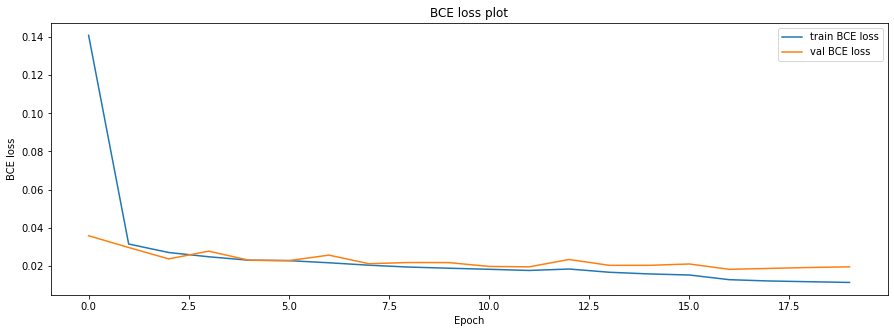

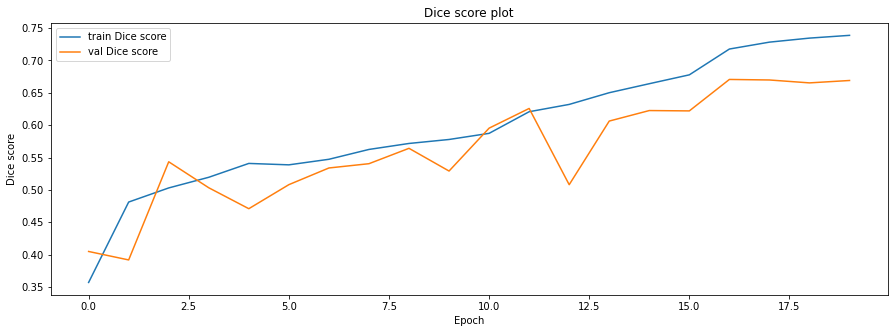

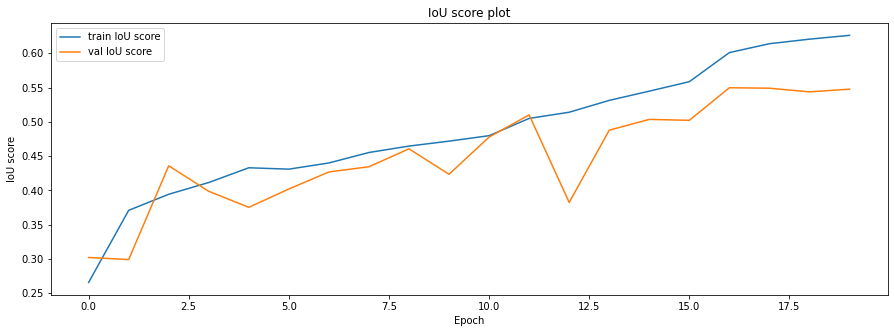

{'train': [0.14092450871684414, 0.031377821982263805, 0.02692270062551527, 0.024682937914918282, 0.022885970570548565, 0.02265646449753089, 0.02153518591578046, 0.02025642876184272, 0.019278412919023078, 0.018669286742806435, 0.018114798363510095, 0.01749548555803513, 0.018253840402906348, 0.01655738226634389, 0.015671883237096455, 0.01511402234217587, 0.012655680217016154, 0.011970192729356047, 0.011587451779545692, 0.011206571248354402], 'val': [0.03573708834924868, 0.02955333907378926, 0.02356993871563602, 0.027625080641536487, 0.02288967199135749, 0.022669203845517977, 0.025545908193591805, 0.0210470045207157, 0.021668099088683015, 0.021623346400225445, 0.019610273019809808, 0.019402176862405168, 0.02325083937362901, 0.020194215572527832, 0.020190174103758875, 0.020897235932006014, 0.01808692907382335, 0.018579550275933884, 0.019053610424245044, 0.019404741918801198]}
{'train': [0.3569189931221527, 0.48117348494912016, 0.5029862518472904, 0.5194444403366548, 0.5408532591303843, 0.5

In [10]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

# print(losses)
# print(dice_scores)
# print(iou_scores)